# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight corrections to the path of light rays and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric describing motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [1]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [2]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# Improved Metric with Quantum Corrections

Here we define improved metric functions that work within the classical SC framework,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

As with the SC metric the improved metric represents a static, spherically symmetric spacetime. Spherical symmetry means we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the magnitude, defined as $L = h(r) \frac{d\phi}{d\lambda}$, is conserved. The metric is independent of 't' so energy, defined as, $E = f(r) \frac{dt}{d\lambda}$ is also conserved. If we integrate once we get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the improved metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \epsilon - \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$


In [3]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# lamda can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    squared = g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) + (epsilon - L**2 / h(r, M, Q_c)))
    dr_dlamda = gr.s.sqrt(max(squared, 0))  # *** ensure non-negative input; obtain real part instead? ***

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# Assign Values to Constants

Assign values for Mass (M) of central massive object, Angular momentum (L) of the orbiting particle, a test value of Energy (E) and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [12]:
# block 2 - assign test values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75
Q_c4 = 1.0

# conserved quantities
# for SC and quantum Geodesics testing I will constrain L and see what happens when I vary total energy E of the particle and 
L1 = 4.3 # angular momentum of orbiting particle
E1 = 1.0 # test value of particle total energy

# calculate and print SC metric components at a given radian distance from the BH and BH mass.
f1 = f(r1, M1, Q_b1, Q_c1)
g1 = g(r1, M1, Q_b1, Q_c1)
h1 = h(r1, M1, Q_c1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.900593754879089
g(r) = 1.11107255028028
h(r) = 400.00000000097657


# Effective Potential and Extrema

We find extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'.

In the case of light ($\epsilon = 0$) there is only a maximum at r = 3 * M when the quantum corrections (QM) = 0.

What follows is a function "find_extrema" that uses OGRePy's numerical function, nsolve to find the roots. For the case of light ($\epsilon = 0$) and a chosen value of angular momentum, L = 4.3 - a number that worked well - we can find the radial position, r, and value of $V_{\text{eff}}(r)$ at the maxima for a range of 13 $Q_b$ values between 0 and 1. Next "find_extrema" is run in a loop saving the $Q_b$ value and r, and $V_{\text{eff}}(r)$ values in an array for subsequent use in plotting trajectories. For this study we can ignore $Q_c$ (set it equal to 0) since $Q_b$ has a much larger effect and $Q_c$ is negligable by comparison. 

Finally we plot $V_{\text{eff}}(r)$ for L = 4.3 and at 13 $Q_b$ values with maximum potential (maxima) marked on the plot.

In [5]:
# block 3 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.0, Q_c = 0.0:
r = 3.7678, v_eff = 1.0803, Type: max
r = 14.7222, v_eff = 0.9379, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.25, Q_c = 0.0:
r = 3.5697, v_eff = 1.1125, Type: max
r = 15.0722, v_eff = 0.9390, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.5, Q_c = 0.0:
r = 3.3772, v_eff = 1.1501, Type: max
r = 15.4143, v_eff = 0.9401, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 0.75, Q_c = 0.0:
r = 3.1893, v_eff = 1.1945, Type: max
r = 15.7496, v_eff = 0.9411, Type: min

Extrema for ε = 1.0, M = 1.0, L = 4.3, Q_b = 1.0, Q_c = 0.0:
r = 3.0047, v_eff = 1.2474, Type: max
r = 16.0789, v_eff = 0.9421, Type: min


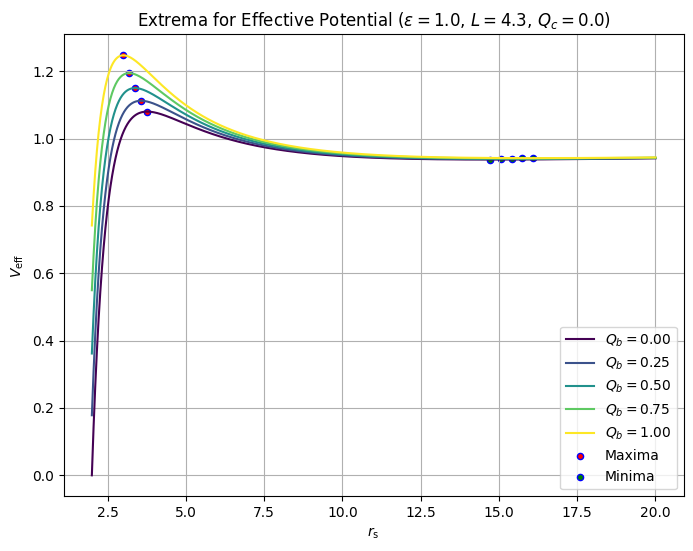

1st row of extrema data points (r, v_eff, Q_b, max/min):
[[3.7677721427714914 1.08027814593156 0.0 'max']]


In [14]:
#block 4 - find v_eff max/min for the timelike case for different values of Q_b and create array for the results
r_range = (rs1, 10 * rs1)
eps = 1.0

Q_b_vals = np.linspace(0, 1.0, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, Q_b, ext_type))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Extrema for Effective Potential ($\varepsilon={eps}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, Q_b val, extrema type
extrema_array = np.array(extrema_data)

# test print
print("1st row of extrema data points (r, v_eff, Q_b, max/min):")
print(extrema_array[:1])


In [7]:
# test code
# print v_eff max, Q_b value for given values of Q_b 
print(extrema_array[:, 0:4])

[[3.7677721427714914 1.08027814593156 0.0 'max']
 [14.722227857228507 0.937870002216587 0.0 'min']
 [3.569650797992037 1.11246547744112 0.25 'max']
 [15.072157796643065 0.939008524092140 0.25 'min']
 [3.377234168744287 1.15013595700006 0.5 'max']
 [15.414291736848671 0.940093998892989 0.5 'min']
 [3.1892770926361913 1.19454847145470 0.75 'max']
 [15.749615999809594 0.941131113700407 0.75 'min']
 [3.0046632605785986 1.24738575169174 1.0 'max']
 [16.0789389511917 0.942123905150500 1.0 'min']]


# Orbits

In this approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp' and $\lambda$ as the independent variable. This results in a list of values which can be converted to cartesian coordinates to plot y(x). We can change direction of $\frac{dr}{d\lambda}$ to list values moving inwards or heading outwards. 

Next we learn the importance of extrema. What follows is the "energy equation" we get by substituting conserved entities, L and E into the equation for $\frac{dr}{d\lambda}$ and rearranging terms,

$$
f(r) g(r) \left(\frac{dr}{d\lambda} \right)^2 + f(r) \left(\frac{L^2}{h(r)} + \epsilon \right) = E^2
$$

The 1st term corresponds to kinetic energy and 2nd term corresponds to gravitational potential energy with total energy ($E^2$) on the right-hand side. At the turning points in a circular orbit radial velocity (therefore kinetic energy) equals zero and the total energy is 100% equal to potential energy.

In the following code block we define the solver function, 'solve_geodesic', then we set 5 sets of initial conditions (all for $Q_b$ = 0 or classical Schwarzschild metric), run the solver, and plot each trajectory together with a plot of $V_{\text{eff}}(r)$ beside it showing the relationship between effective potential and total energy.

In [15]:
# block 5 - solver for geodesics equations for plotting orbits
def solve_geodesic(r_init, phi_init, t_init, lam_range, params, epsilon=0, inward=True):
    E, L, M, Q_b, Q_c = params
    y0 = [t_init, r_init, phi_init]
    last_sq = None  # store previous value of (dr/dλ)^2

    def dy_dt(lam, y):
        nonlocal inward, last_sq
        t, r, phi = y

        # stop integration if r is too close to Schwarzschild radius
        if r <= 2 * M + 1e-3:
            return [0, 0, 0]  

        f_r = f(r, M, Q_b, Q_c)
        g_r = g(r, M, Q_b, Q_c)
        h_r = h(r, M, Q_c)

        dt_dlamda = E / f_r
        dphi_dlamda = L / h_r

        squared = g_r**(-1) * (E**2 / f_r + (epsilon - L**2 / h_r))

        # use for debugging
        # print(f"At r = {r:.4f}, (dr/dλ)^2 = {squared:.6f}, inward = {inward}")

        # flip direction at sign change (turning point)
        if last_sq is not None and np.sign(squared) != np.sign(last_sq):
            inward = not inward

        # store current value
        last_sq = squared

        dr_dlamda = gr.s.sqrt(abs(squared))

        # enforce motion direction
        if inward:
            dr_dlamda = -abs(dr_dlamda)  # inward
        else:
            dr_dlamda = abs(dr_dlamda)   # outward

        return [dt_dlamda, dr_dlamda, dphi_dlamda]

    # solve for t(λ), r(λ), and φ(λ)
    sol = solve_ivp(dy_dt, lam_range, y0, t_eval=np.linspace(*lam_range, 1000), atol=1e-5, rtol=1e-5)

    return sol


# Particle Orbits for a classical Schwarzschild metric

For M = 1.0 and L = 4.3 there is a circular orbit at 3 * M exactly at the effective potential maxima. If our light ray begins a path outside 3 * M (lets say at 5 times $r_{\text{sc}}$) and travels inwards, the light ray will be scattered after a turning point, if it has energy less than the maximum potential or it will plunge into the BH with energy greater than the maximum potential. Conversely, if the light ray begins between $r_{\text{sc}}$ and 3 * M, say at 2.4 * M, it will escape with energy greater than the maximum potential and plunge into the black hole with energy less than the maximum potential.

Next: using the array of maxima for $V_{\text{eff}}(r)$ for different values of $Q_b$ we have the location for a perfect circular plot. We should see similar scattering and plunging situations but for shifted values of energy as compared to the classic SC metric. 

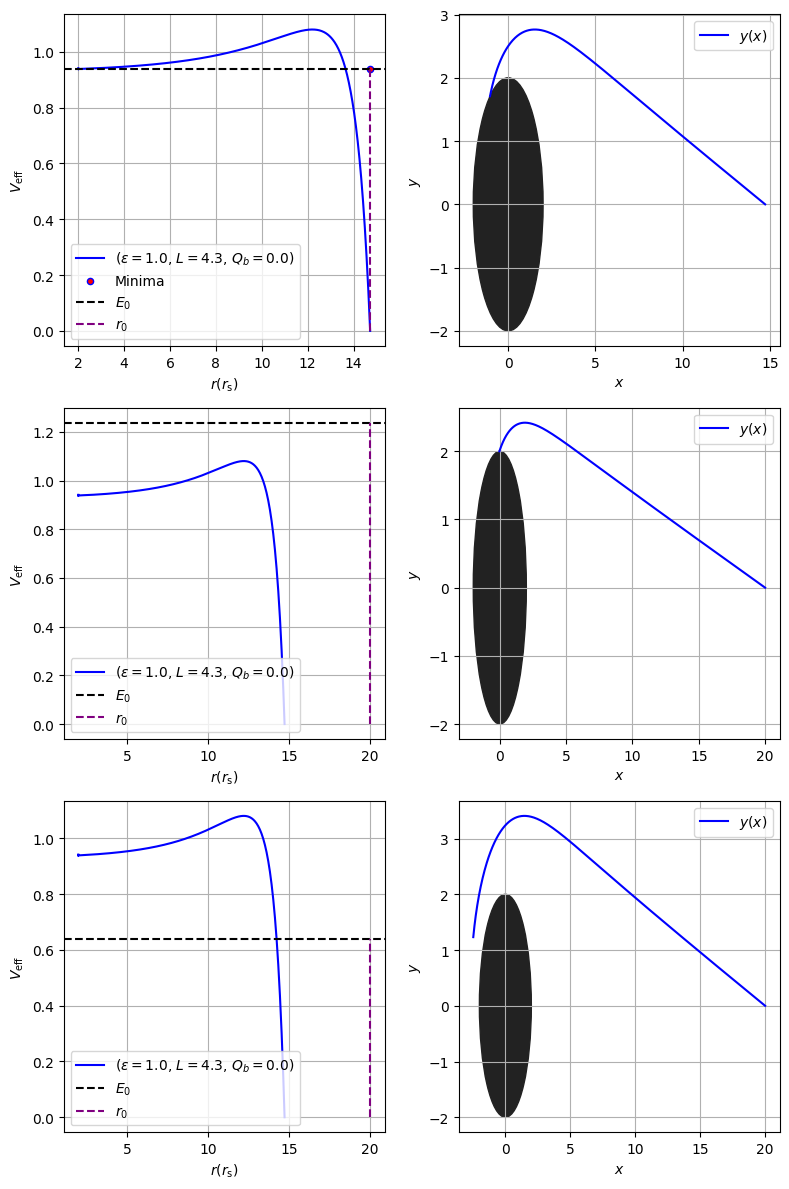

In [24]:
# block 6 - plot geodesics
# same for all massive particles around a SC black hole
eps = 1.0
Qb0_1 = extrema_array[1, 2]
Qc0_1 = 0.0
phi0_1 = 0
t0_1 = 0
tau_span_1 = [0, 20]
r0_1 = 10 * rs1 # far out starting point
r_circ1_1 = extrema_array[1, 0]
E1_1 = extrema_array[1, 1] #v_eff at max (= E)
#----------- circular orbit
params1_1 = (E1_1, L1, M1, Qb0_1, Qc0_1)

r_vals1_1 = np.linspace(rs1, 10*rs1, 1000)
v_eff1_1 = np.array([v_eff(i, M1, L1, Qb0_1, Qc0_1, epsilon=1.0) for i in r_vals1_1])

sol1_1 = solve_geodesic(r_circ1_1, phi0_1, t0_1, tau_span_1, params1_1, epsilon=1.0, inward=True)

t_vals1_1 = sol1_1.y[0]
r_vals1_1 = sol1_1.y[1]
phi_vals1_1 = sol1_1.y[2]

# cartesian coordinates
x_vals1_1 = r_vals1_1 * np.cos(phi_vals1_1)
y_vals1_1 = r_vals1_1 * np.sin(phi_vals1_1)

#---------- E greater than circular -------------
E1_2 = E1_1 + 0.30
params2_1 = (E1_2, L1, M1, Qb0_1, Qc0_1)

sol2_1 = solve_geodesic(r0_1, phi0_1, t0_1, tau_span_1, params2_1, epsilon=1.0, inward=True)

t_vals2_1 = sol2_1.y[0]
r_vals2_1 = sol2_1.y[1]
phi_vals2_1 = sol2_1.y[2]

# cartesian coordinates
x_vals2_1 = r_vals2_1 * np.cos(phi_vals2_1)
y_vals2_1 = r_vals2_1 * np.sin(phi_vals2_1)

#---------- E less than circular -------------
E1_3 = E1_1 - 0.30
params3_1 = (E1_3, L1, M1, Qb0_1, Qc0_1)

sol3_1 = solve_geodesic(r0_1, phi0_1, t0_1, tau_span_1, params3_1, epsilon=1.0, inward=True)

t_vals3_1 = sol3_1.y[0]
r_vals3_1 = sol3_1.y[1]
phi_vals3_1 = sol3_1.y[2]

# cartesian coordinates
x_vals3_1 = r_vals3_1 * np.cos(phi_vals3_1)
y_vals3_1 = r_vals3_1 * np.sin(phi_vals3_1)
#--------- Plots -------------
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

# First plot
axes[0, 0].plot(r_vals1_1, v_eff1_1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0_1}$)", color='b')
axes[0, 0].scatter(extrema_array[1,0], extrema_array[1,1], color='r', s=20, edgecolors='b', label="Minima")
axes[0, 0].axhline(y=E1_1, color='black', linestyle='--', label=r'$E_0$')
axes[0, 0].vlines(x=r_circ1_1, ymin=min(v_eff1_1), ymax=E1_1, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals1_1, y_vals1_1, label=r'$y(x)$', color='blue')
circle1_1 = patches.Circle((0, 0), 2*M1, color='#222222', alpha=1.0)
axes[0, 1].add_patch(circle1_1)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_vals1_1, v_eff1_1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0_1}$)", color='b')
axes[1, 0].axhline(y=E1_2, color='black', linestyle='--', label=r'$E_0$')
axes[1, 0].vlines(x=r0_1, ymin=min(v_eff1_1), ymax=E1_2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals2_1, y_vals2_1, label=r'$y(x)$', color='blue')
circle2_1 = patches.Circle((0, 0), 2*M1, color='#222222', alpha=1.0)
axes[1, 1].add_patch(circle2_1)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_vals1_1, v_eff1_1, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb0_1}$)", color='b')
axes[2, 0].axhline(y=E1_3, color='black', linestyle='--', label=r'$E_0$')
axes[2, 0].vlines(x=r0_1, ymin=min(v_eff1_1), ymax=E1_3, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# 6th plot
axes[2, 1].plot(x_vals3_1, y_vals3_1, label=r'$y(x)$', color='blue')
circle3_1 = patches.Circle((0, 0), 2*M1, color='#222222', alpha=1.0)
axes[2, 1].add_patch(circle3_1)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

plt.tight_layout()
plt.show()
#---------------------------


# Orbits - method 2

In the 2nd approach we find $r(\phi)$ using the following expression,

$$\frac{dr}{d\phi} = \frac{\dot{r}}{\dot{\phi}} = \frac{h(r)}{L} \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \epsilon - \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$

then integrate using 'solve_ivp' and plot in polar format. In the next code block we define a solver named 'solve_geodesic2' then in the following code block we set initial conditions, run the solver, and plot the orbit.

In [28]:
# block 7 - solve for r(phi)
# define dr/dphi solver function for integration
def solve_geodesic2(params, phi_range, r_init, epsilon=0):
    
    E, L, M, Q_b, Q_c, r_max = params  # unpack parameters
    
    def dr_dphi(phi, y):
        r = y[0]
        corr = 1e-6
        
        # stop integration if r is out of bounds
        if r <= rs1 + corr or r >= r_max:
            return [0] 
        
        hh = h(r, M, Q_c)
        ff = f(r, M, Q_b, Q_c)
        gg = g(r, M, Q_b, Q_c)
        dr_dphi = (hh / L) * gr.s.sqrt(max(0, 1 / gg * (E**2 / ff + (epsilon - L**2 / hh))))
        return [dr_dphi]
    
    # Solve the ODE
    sol = solve_ivp(dr_dphi, phi_range, [r_init], t_eval=np.linspace(*phi_range, 1000), atol=1e-5, rtol=1e-5)
    return sol

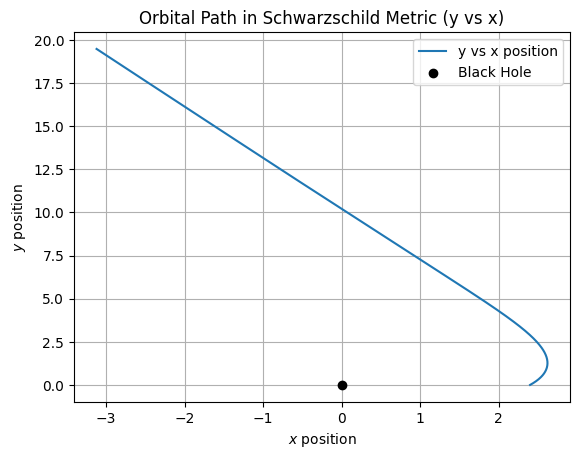

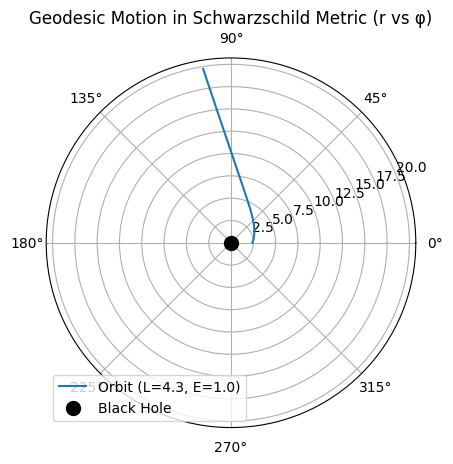

In [30]:
# Block 8
# initial conditions
phi_range2_1 = (0, 2 * np.pi)
r_init2_1 = 1.2 * rs1
r_max2_1 = 10 * rs1
params2_1 = [E1_1, L1, M1, Qb0_1, Qc0_1, r_max2_1]
sol_10 = solve_geodesic2(params2_1, phi_range2_1, r_init2_1, epsilon=1.0)

# extract solution
phi_vals2_1 = sol_10.t
r_vals2_1 = sol_10.y[0]
valid_ind = r_vals2_1 <= r_max2_1
phi_vals3_1 = phi_vals2_1[valid_ind]
r_vals3_1 = r_vals2_1[valid_ind]

# convert to cartesian coords
x2_1 = r_vals3_1 * np.cos(phi_vals3_1)
y2_1 = r_vals3_1 * np.sin(phi_vals3_1)
 
# cartesian coordinates
plt.plot(x2_1, y2_1, label=f'y vs x position')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.title('Orbital Path in Schwarzschild Metric (y vs x)')
plt.legend()
plt.grid(True)
plt.show()

# plar plot
plt.polar(phi_vals3_1, r_vals3_1, label=f'Orbit (L={L1}, E={E1})')
plt.scatter([0], [0], color='black', marker='o', s=100, label='Black Hole', zorder=5)
plt.title('Geodesic Motion in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()